In [203]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

%matplotlib inline

### Get VTI history

In [2]:
vti = yf.Ticker("VTI")
vti_hist = vti.history(period="max")

#### Visualy look for trends

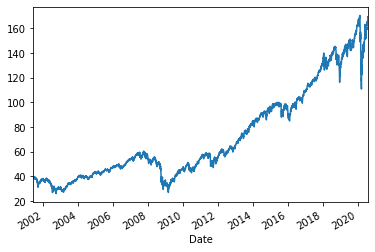

In [12]:
vti_hist.Close.plot()

#### Create testing set

In [130]:
train_size = int(len(vti_hist) * 0.9)
test_size = len(vti_hist) - train_size
train, test = vti_hist.iloc[0:train_size], vti_hist.iloc[train_size:len(vti_hist)]
print(len(train), len(test))

4335 482


In [ ]:
# NOT SURE I NEED THESE FOR ARIMA
# timeseries version of train test split
# def create_dataset(X, y, time_steps=1):
#     Xs, ys = [], []
#     for i in range(len(X) - time_steps):
#         v = X.iloc[i:(i + time_steps)].values
#         Xs.append(v)        
#         ys.append(y.iloc[i + time_steps])
#     return np.array(Xs), np.array(ys)

In [ ]:
# NOT SURE I NEED THIS
# time_steps = 1

# # reshape to [samples, time_steps, n_features]
# X_train, y_train = create_dataset(train, train.vti, time_steps)
# X_test, y_test = create_dataset(test, test.vti, time_steps)

# print(X_train.shape, y_train.shape)

#### test for stationarity

In [131]:
dfuller_results = adfuller(train.Close)

In [132]:
pd.Series(dfuller_results[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                    2.245578
p-value                           0.998918
#Lags Used                       18.000000
Number of Observations Used    4316.000000
dtype: float64

In [133]:
train_diff = train.diff()

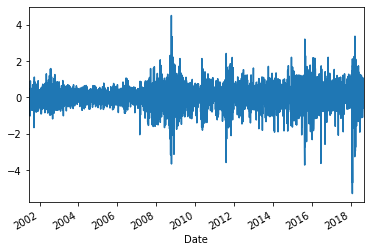

In [134]:
train_diff.Close.plot()

In [135]:
dfuller_results = adfuller(train_diff[1::].Close)

In [136]:
pd.Series(dfuller_results[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                -1.641792e+01
p-value                        2.546733e-29
#Lags Used                     1.600000e+01
Number of Observations Used    4.317000e+03
dtype: float64

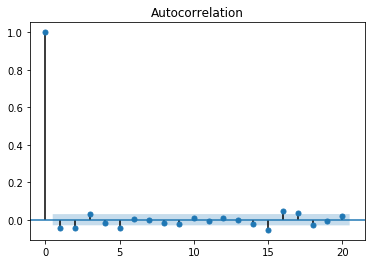

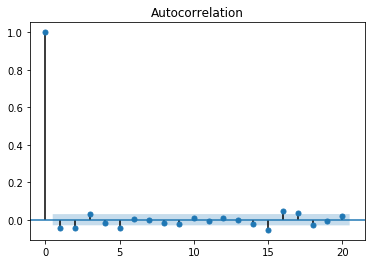

In [137]:
plot_acf(train_diff[1::].Close, alpha=.05, lags=20)

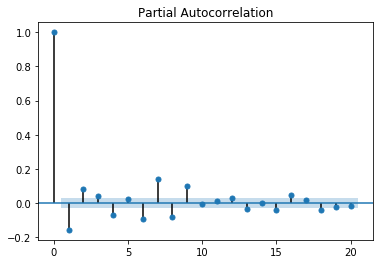

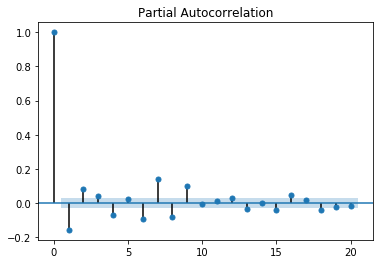

In [62]:
plot_pacf(vti_diff[1::].Close, alpha=.05, lags=20)

In [172]:
arimodel = ARIMA(train_diff[1::].Close, order=(5,1,1))
model_fit = arimodel.fit(disp=0)
print(model_fit.summary())

/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4333
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -4190.717
Method:                       css-mle   S.D. of innovations              0.636
Date:                Tue, 11 Aug 2020   AIC                           8397.435
Time:                        20:50:33   BIC                           8448.427
Sample:                             1   HQIC                          8415.437
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.748e-05   6.95e-06      2.516      0.012    3.86e-06    3.11e-05
ar.L1.D.Close    -0.0413      0.015     -2.724      0.006      -0.071      -0.012
ar.L2.D.Close    -0.0457      0.015     

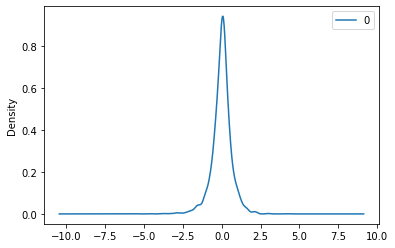

In [173]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(kind='kde')

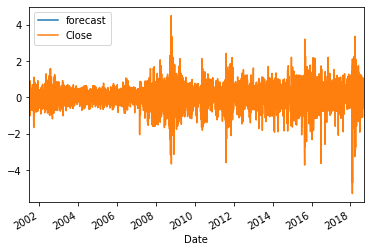

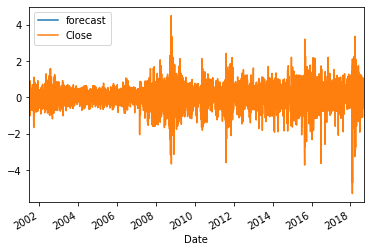

In [174]:
model_fit.plot_predict()

In [206]:
pred_diffs = model_fit.forecast(len(test)-1)[0]

In [207]:
last_values = [train.iloc[-1].Close]
for index, diff in enumerate(pred_diffs):
    last_values.append(last_values[index]+diff)
preds = last_values    

In [241]:
print("RMSE = ", np.sqrt(mean_squared_error(test.Close, preds)))

RMSE =  15.857369000241645


In [234]:
viz_df = test

In [237]:
viz_df['preds'] = pd.Series(preds).values

/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


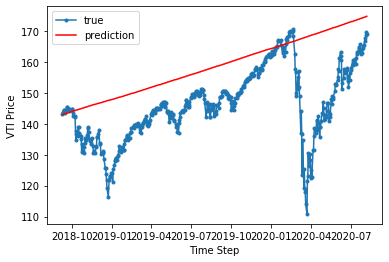

In [239]:
plt.plot(viz_df.Close, marker='.', label="true")
plt.plot(viz_df.preds, 'r', label="prediction")
plt.ylabel('VTI Price')
plt.xlabel('Time Step')
plt.legend()
plt.show();